In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import  transforms

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
train_dir = '../ViT/custom_dataset/227.v1i.folder/train'
test_dir = '../ViT/custom_dataset/227.v1i.folder/test'

### Create Datasets and DataLoaders

In [11]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [12]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           

In [13]:
# Set the batch size
BATCH_SIZE = 32 

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x297882dca08>,
 ['Bush Clock Vine',
  'Common Lanthana',
  'Datura',
  'Hibiscus',
  'Jatropha',
  'Marigold',
  'Nityakalyani',
  'Rose',
  'Yellow_Daisy',
  'adathoda',
  'banana',
  'champaka',
  'chitrak',
  'crown flower',
  "four o'clock flower",
  'honeysuckle',
  'indian mallow',
  'malabar melastome',
  'nagapoovu',
  'pinwheel flower',
  'shankupushpam',
  'spider lily',
  'sunflower',
  'thechi',
  'thumba',
  'touch me not',
  'tridax procumbens',
  'wild_potato_vine'])

torch.Size([3, 224, 224]) tensor(25)


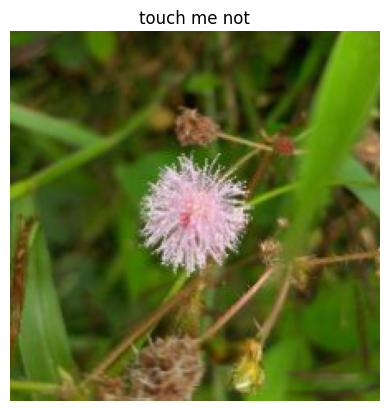

In [14]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

### ViT Start

### Training

In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

In [17]:
# 입력 이미지 patch로 분리하기
x = torch.randn(8, 3, 224, 224)

patch_size = 16
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)',
                    s1 = patch_size, s2 = patch_size) # (batch channel height width) => (batch patchNum patchSize)
print('patches : ', patches.shape)

patches :  torch.Size([8, 196, 768])


In [18]:
# Conv를 사용하면 성능이 더 좋아진다고 함
patch_size = 16
in_channel = 3
emb_size = 3 * 16 * 16

projection = nn.Sequential(
    nn.Conv2d(in_channel, emb_size, kernel_size=patch_size, stride=patch_size),
    Rearrange('b e (h) (w) -> b (h w) e'))

summary(projection, x.shape[1:], device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 2.30
Params size (MB): 2.25
Estimated Total Size (MB): 5.12
----------------------------------------------------------------


In [19]:
emb_size = 768
img_size = 224
patch_size = 16

projected_x = projection(x)

cls_token = nn.Parameter(torch.randn(1,1,emb_size))
positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))
print('Cls Shape :', cls_token.shape, ', Pos Shape :', positions.shape)

batch_size = 8
cls_tokens = repeat(cls_token, '() n e -> b n e', b = batch_size) # batch 수에 맞게 cls_token 생성
print('cls_token :', cls_tokens.shape)

cat_x = torch.cat([cls_tokens, projected_x], dim=1)
print('cat_x : ', cat_x.shape)

cat_x += positions
print('output : ', cat_x.shape)

Cls Shape : torch.Size([1, 1, 768]) , Pos Shape : torch.Size([197, 768])
cls_token : torch.Size([8, 1, 768])
cat_x :  torch.Size([8, 197, 768])
output :  torch.Size([8, 197, 768])


In [20]:
# 클래스 형태로 만들기
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, 
                 emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e')
        )
        self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))
        self.positions = nn.Parameter(torch.randn((img_size//patch_size) ** 2 + 1, emb_size))
    
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b = b)
        x = torch.cat([cls_tokens, x], dim= 1)
        x += self.positions

        return x

PE = PatchEmbedding()
summary(PE, (3, 224, 224), device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 2.30
Params size (MB): 2.25
Estimated Total Size (MB): 5.12
----------------------------------------------------------------


In [31]:
# Multi-Head Attention
x = torch.randn(8, 3, 224, 224)

emb_size = 3 * 16 * 16 
num_heads = 8

keys = nn.Linear(emb_size, emb_size)
queries = nn.Linear(emb_size, emb_size)
values = nn.Linear(emb_size, emb_size)

x = PE(x)
print(queries(x).shape)

keys = rearrange(keys(x), 'b n (h d) -> b h n d', h=num_heads) # head 숫자만큼 차원을 쪼갬
queries = rearrange(queries(x), 'b n (h d) -> b h n d', h=num_heads)
values = rearrange(values(x), 'b n (h d) -> b h n d', h=num_heads)

print('shape :', queries.shape, keys.shape, values.shape)

torch.Size([8, 197, 768])
shape : torch.Size([8, 8, 197, 96]) torch.Size([8, 8, 197, 96]) torch.Size([8, 8, 197, 96])


In [49]:
# queries * key
energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
print('energy :', energy.shape)

# Attention Score
scaling = emb_size **(1/2)
att = F.softmax(energy/scaling, dim=-1)
print('att :', att.shape)

# Attention Score * values
out = torch.einsum('bhal, bhlv -> bhav', att, values)
print('out :', out.shape)

# rearrange to emb_size
out = rearrange(out, 'b h n d -> b n (h d)') # multi-head를 하나로 모음
print('out2 : ', out.shape)

energy : torch.Size([8, 8, 197, 197])
att : torch.Size([8, 8, 197, 197])
out : torch.Size([8, 8, 197, 96])
out2 :  torch.Size([8, 197, 768])


In [50]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split q, k, v in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]

        # queries * key
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy/ scaling, dim=-1)
        att = self.att_drop(att)

        # Attention Score * values
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        
        # multi-head를 하나로 모음
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    

x = torch.randn(8, 3, 224, 224)
PE = PatchEmbedding()
x = PE(x)
print(x.shape)
MHA = MultiHeadAttention()
summary(MHA, x.shape[1:], device='cpu')


torch.Size([8, 197, 768])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 197, 2304]       1,771,776
           Dropout-2          [-1, 8, 197, 197]               0
            Linear-3             [-1, 197, 768]         590,592
Total params: 2,362,368
Trainable params: 2,362,368
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.58
Forward/backward pass size (MB): 6.99
Params size (MB): 9.01
Estimated Total Size (MB): 16.57
----------------------------------------------------------------


In [63]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x
    
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )
# README에 언급한 TransformerEncoder 구조
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion= forward_expansion, drop_p=forward_drop_p),
                    nn.Dropout(drop_p)
                )
            ))
x = torch.randn(8, 3, 224, 224)
x = PE(x)
TE = TransformerEncoderBlock()
summary(TE, x.shape[1:], device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1             [-1, 197, 768]           1,536
            Linear-2            [-1, 197, 2304]       1,771,776
           Dropout-3          [-1, 8, 197, 197]               0
            Linear-4             [-1, 197, 768]         590,592
MultiHeadAttention-5             [-1, 197, 768]               0
           Dropout-6             [-1, 197, 768]               0
       ResidualAdd-7             [-1, 197, 768]               0
         LayerNorm-8             [-1, 197, 768]           1,536
            Linear-9            [-1, 197, 3072]       2,362,368
             GELU-10            [-1, 197, 3072]               0
          Dropout-11            [-1, 197, 3072]               0
           Linear-12             [-1, 197, 768]       2,360,064
          Dropout-13             [-1, 197, 768]               0
      ResidualAdd-14             [-1, 1

In [64]:
# Final 
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

# 해당 방식은 cls 토큰만 사용하는 것이 아닌 전체 토큰에 평균을 취해 하나로 변환한 후 classification을 진행함
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12, # 적용시킬 Transformer Encoder 갯수 
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )
        
summary(ViT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6          [-1, 8, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
MultiHeadAttention-8             [-1, 197, 768]               0
           Dropout-9             [-1, 197, 768]               0
      ResidualAdd-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear-12            [-1, 197, 3072]       2,362,368
             GELU-13            [-1, 197, 3072]               0
          Dropout-14            [-1, 19